In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

# NetCDF Data

The [Network Common Data Form (NetCDF)](https://www.unidata.ucar.edu/software/netcdf/) is a convenient and efficient format for storing array-oriented scientific data. A mental model for this format represents a variable by a multi-dimensional grid of values. The diagram in {numref}`Figure %s <netCDF-diagram>` shows the concept. A variable such as rainfall is recorded daily at places around the globe. We can imagine these rainfall values arranged in a cube with longitude running along one side of the cube, latitude along another, and date in the third dimension. Each cell in the cube holds the rainfall recorded for one day at a particular location. A NetCDF file also contains information, which we call metadata, about the dimensions of the cube. The same information in a data frame would be organized quite differently in a data frame, where we would need three features for latitude, longitude, and date for each rainfall measurement. This would mean repeating lots of data. With a NetCDF file, we don't need to repeat the latitude and longitude values for each day, nor the dates for each location.

```{figure} figures/netCDF-diagram.png
---
name: netCDF-diagram
---

This diagram represents a model for NetCDF data. The data are organized into a three-dimensional array that contains recordings of rainfall at locations in time (latitude, longitude, and time). The "X" marks one rainfall measurement for a specific location on a particular date.
```

NetCDF has several other advantages, in addition to being more compact:

+ scalable - efficient access to subsets of the data
+ appendable - easily add new data without redefining the structure
+ sharable - common format that's independent of the coding language and operating system
+ self-describing - the source file contains both a description of the data's organization and the data itself
+ community - general tools made available by a community of users

NetCDF variables are not limited to three-dimensions. For example, elevation could be added to our earth science application so that we have recordings of, say, temperature,  in time, latitude, longitude, and elevation. And, dimensions need not correspond to physical dimensions. Climate scientists often run several models and store the model number in a dimension along with the model output. While NetCDF was originally developed for atmospheric scientists at the University Corporation for Atmospheric Research (UCAR), the format has gained popularity and is now used at thousands of educational, research and government sites around the world. And, the applications have expanded to areas, such as astronomy and physics with the [Smithsonian/NASA Astrophysics Data System (ADS)](https://science.nasa.gov/astrophysics/astrophysics-data-centers/smithsonian-nasa-astrophysics-data-system-ads) and medical imaging with [Medical Image NetCDF (MINC)](http://www.bic.mni.mcgill.ca/software/minc/minc.html). 

NetCDF files have three basic components: dimensions, variables, and various sorts of metadata. The *variable* contains what we think of as the data, such as the rainfall recordings. Each variable has a name, storage type, and shape, meaning the number of dimensions. The *dimensions* component gives each dimension's name and number of grid points. Additional information is provided by the *coordinates*. In particular the points at which the measurements are made, such as for longitude, where these might be: $0.0, 0.25, 0.50, \ldots, 359.75$.  Other metadata, include *attributes*. Attributes for a variable can hold ancillary information about the variables, and other attributes contain global information about the file, such as who published the dataset, their contact information, and permissions for using the data. This global information is critical to ensure reproducible results.  

The following example examines the components of a particular NetCDF file and demonstrates how to extract portions of data from variables. 

## Example: Rainfall Around the World

The [Climate Data Store](https://cds.climate.copernicus.eu/) provides a collection of data sets from various climate sectors and services. We visited their site and requested measurements of temperature and total precipitation for a two-week period in Dec 2022. Let's walk through a brief examination of these data to get a sense of the organization of the components in the file, how to extract subsets, and make visualizations.

The data are in the NetCDF file `CDS_ERA5_22-12.nc`. Let's first figure out how large the file is ({numref}`Chapter %s <ch:files>`). 

In [2]:
from pathlib import Path
import os

file_path = Path() / 'data' / 'CDS_ERA5_22-12.nc'

kib = 1024
size = os.path.getsize(file_path)
np.round(size / kib**3)

2.0

Despite having only three variables (total precipitation, rain rate, temperature) for two weeks, the file is two GiB in size! These climate sources often tend to be quite large.

The `xarray` package is useful for working with array-like data and, in particular, NetCDF. We use its functionality to explore the components of our climate file.  First we open the file.

In [3]:
import xarray as xr

ds = xr.open_dataset(file_path)

Now, let's check the dimensions component of the file.

In [4]:
ds.dims

Frozen(SortedKeysDict({'longitude': 1440, 'latitude': 721, 'time': 408}))

Like in {numref}`Figure %s <netCDF-diagram>`, our file has three dimensions, longitude, latitude and time. The sizes of each dimension tells us that there are over 400,000 cells of data values ($1440 * 721 * 408$). If these data were in a data frame, then it would have 400,000 rows with latitude, longitude, and time columns in great repetition! Instead, we only need their values once, and the coordinates component gives us them.

In [5]:
ds.coords

Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2022-12-15 ... 2022-12-31T23:00:00

Each variable in our file is three-dimensional. Actually, a variable doesn't have to have all three dimensions, but in our example they do.  

In [6]:
ds.data_vars

Data variables:
    t2m      (time, latitude, longitude) float32 ...
    lsrr     (time, latitude, longitude) float32 ...
    tp       (time, latitude, longitude) float32 ...

Metadata for a variable provides the units and a longer description. While metadata for the source gives us information such as when we retrieved the data.

In [7]:
ds.tp.attrs

{'units': 'm', 'long_name': 'Total precipitation'}

In [8]:
ds.attrs

{'Conventions': 'CF-1.6',
 'history': '2023-01-19 19:54:37 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data6/adaptor.mars.internal-1674158060.3800251-17201-13-c46a8ac2-f1b6-4b57-a14e-801c001f7b2b.nc /cache/tmp/c46a8ac2-f1b6-4b57-a14e-801c001f7b2b-adaptor.mars.internal-1674158033.856014-17201-20-tmp.grib'}

By keeping all of these pieces of information in the source file itself, we don't risk losing it or having the description get out of sync with the data.

Like with `pandas`, `xarray` provides many different ways to select portions of the data to work with. We show two examples. First, we focus on one specific location and examine the total precipitation in time with a line plot. 

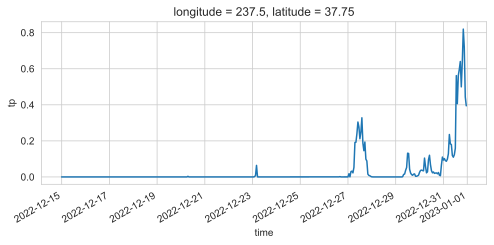

In [9]:
(ds.sel(latitude=37.75, longitude=237.5).tp * 100).plot(figsize=(8,3));

Next we choose one date, Dec 31, 2022 at 1 pm, and narrow down the latitude and longitude to the continental United States to make a map of temperature.   

In [10]:
import datetime
one_day = datetime.datetime(2022, 12, 31, 13, 0, 0)

In [11]:
min_lon, min_lat, max_lon, max_lat = 232, 21, 300, 50

mask_lon = (ds.longitude > min_lon) & (ds.longitude < max_lon)
mask_lat = (ds.latitude > min_lat) & (ds.latitude < max_lat)

ds_oneday_us = ds.sel(time=one_day).t2m.where(mask_lon & mask_lat, drop=True)

Like `loc` for data frames, `sel` returns a new `DataArray` whose data is determined by the index labels along the specified dimension, which for this example is the date. And, like `np.where`, `xr.where` returns elements depending on the logical condition provided. We use `drop=True` to reduce the size of the dataset.

Let's make a chloropleth map of temperature, where color represents the temperature.  

In [12]:
ds_oneday_us.plot(figsize=(8,4));

We can make out the shape of the US, the warm Caribbean, and the colder mountain ranges from this map.

We wrap up by closing the file. 

In [13]:
ds.close()

This brief introduction to NetCDF is meant to touch on the basic concepts. Our main goal is to show that other kinds of data formats exist and can have advantages over plain text read into a dataframe. For interested readers, NetCDF has a rich ecosystem of packages and functionality. For example, in addition to the `xarray` module, NetCDF files can be read with other Python modules like [`netCDF4`](http://unidata.github.io/netcdf4-python/) and [`gdal`](https://gdal.org/drivers/raster/netcdf.html). The NetCDF community has also provided command-line tools for interacting with NetCDF data. And, to make visualizations and maps, options include `matplotlib`, [`iris`](https://scitools-iris.readthedocs.io/en/stable/) which is built on top of `netCDF4`, and [`cartopy`](https://scitools.org.uk/cartopy/docs/latest/).

Next we consider the JSON format, which offers more flexibility to represent hierarchical data compared to the CSV and FWF formats.